# Energy Time Series Forecasting

## Introduction

Prédiction de la consommation d’énergie du business groupe dans Alesund à partir des données historiques.

## Import des bibliothèques

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

## Chargement des données 

In [27]:
df_alesund_data = pd.read_csv("meteo_consump_alesund_data.csv")  
df_alesund_data.head()

,Consumption_group_Ålesund,VOLUME_KWH,METERINGPOINT_COUNT,Date,wind_speed,t2m_C,surface_pressure
0,private,57961.562,27060,2021-01-01 00:00:00,2.798005,1.68923,98874.56
1,industry,13558.855,1029,2021-01-01 00:00:00,2.798005,1.68923,98874.56
2,business,30582.870,3784,2021-01-01 00:00:00,2.798005,1.68923,98874.56
3,private,56258.645,27060,2021-01-01 01:00:00,2.630726,1.32168,98905.06
4,industry,13649.810,1029,2021-01-01 01:00:00,2.630726,1.32168,98905.06


## Filtrage des données de business groupe 

In [28]:
# Filtrer pour ne garder que les lignes où la colonne est égale à "business"
df_business_consumption= df_alesund_data[df_alesund_data['Consumption_group_Ålesund'] == 'business']

# Supprimer la colonne après le filtrage
df_business_consumption = df_business_consumption.drop(columns=['Consumption_group_Ålesund'])
df_business_consumption=df_business_consumption.reset_index(drop=True)
df_business_consumption.head()

,VOLUME_KWH,METERINGPOINT_COUNT,Date,wind_speed,t2m_C,surface_pressure
0,30582.870,3784,2021-01-01 00:00:00,2.798005,1.68923,98874.560
1,30352.254,3784,2021-01-01 01:00:00,2.630726,1.32168,98905.060
2,30774.594,3784,2021-01-01 02:00:00,2.387332,1.01553,98930.625
3,30846.584,3784,2021-01-01 03:00:00,1.984651,0.77847,98928.000
4,31745.682,3784,2021-01-01 04:00:00,1.515596,0.66543,98949.560


## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [30]:
df_business_consumption=pd.read_csv('business_group_data.csv')

In [31]:
df_business_consumption['Date'] = pd.to_datetime(
    df_business_consumption['Date'])

In [32]:
# Création de la nouvelle colonne
df_business_consumption["Consommation"] = df_business_consumption["VOLUME_KWH"] / df_business_consumption["METERINGPOINT_COUNT"]

# Suppression des deux colonnes d'origine
df_business_consumption.drop(columns=["VOLUME_KWH", "METERINGPOINT_COUNT"], inplace=True)


## Feature engineering

In [33]:

# Extraire les composants de date
df_business_consumption['hour'] = df_business_consumption['Date'].dt.hour
df_business_consumption['month'] = df_business_consumption['Date'].dt.month
df_business_consumption['weekday'] = df_business_consumption['Date'].dt.weekday  # 0 = lundi, 6 = dimanche
df_business_consumption['dayofyear'] = df_business_consumption['Date'].dt.dayofyear

# Vérification
df_business_consumption.head()


,Date,wind_speed,t2m_C,surface_pressure,Consommation,hour,month,weekday,dayofyear
0,2021-01-01 00:00:00,2.798005,1.68923,98874.560,8.082154,0,1,4,1
1,2021-01-01 01:00:00,2.630726,1.32168,98905.060,8.021209,1,1,4,1
2,2021-01-01 02:00:00,2.387332,1.01553,98930.625,8.132821,2,1,4,1
3,2021-01-01 03:00:00,1.984651,0.77847,98928.000,8.151846,3,1,4,1
4,2021-01-01 04:00:00,1.515596,0.66543,98949.560,8.389451,4,1,4,1


##  Prétraitement des données

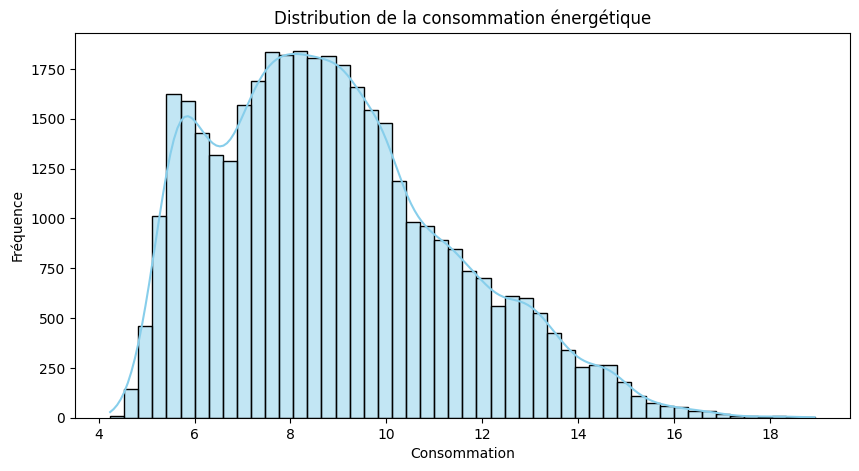

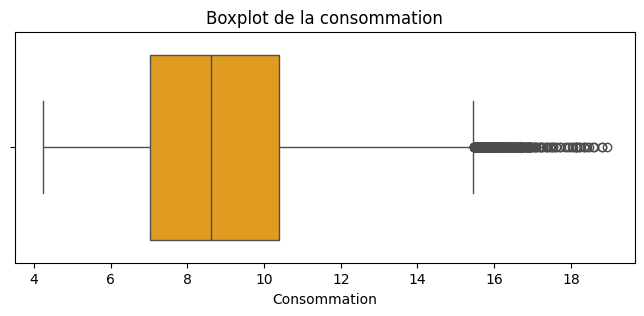

In [35]:

# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["Consommation"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la consommation énergétique")
plt.xlabel("Consommation")
plt.ylabel("Fréquence")
plt.show()

# Boxplot (pour voir les outliers)
plt.figure(figsize=(8, 3))
sns.boxplot(x=df_business_consumption["Consommation"], color="orange")
plt.title("Boxplot de la consommation")
plt.show()


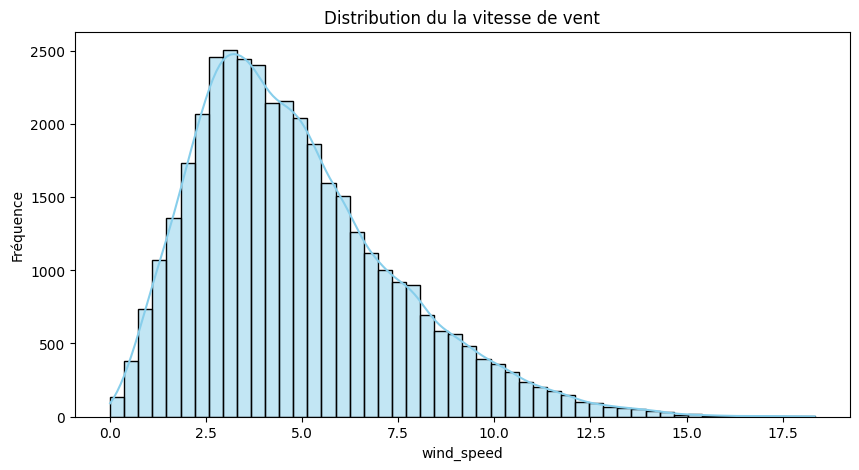

In [36]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["wind_speed"], bins=50, kde=True, color="skyblue")
plt.title("Distribution du la vitesse de vent")
plt.xlabel("wind_speed")
plt.ylabel("Fréquence")
plt.show()


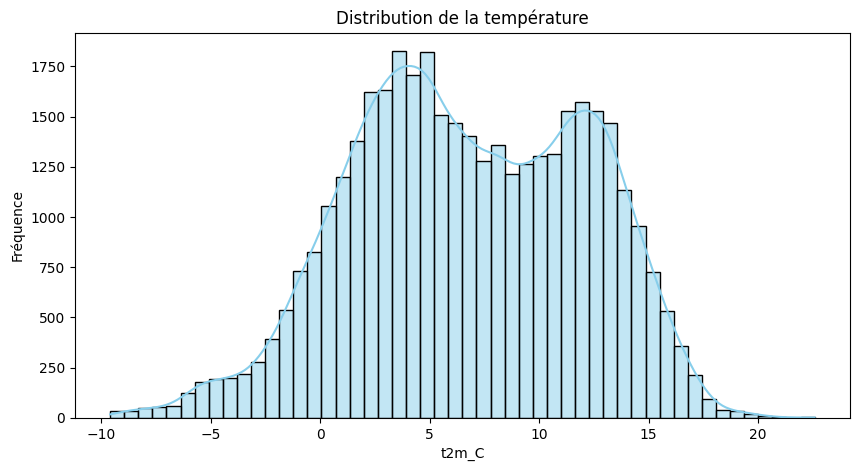

In [37]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["t2m_C"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la température")
plt.xlabel("t2m_C")
plt.ylabel("Fréquence")
plt.show()

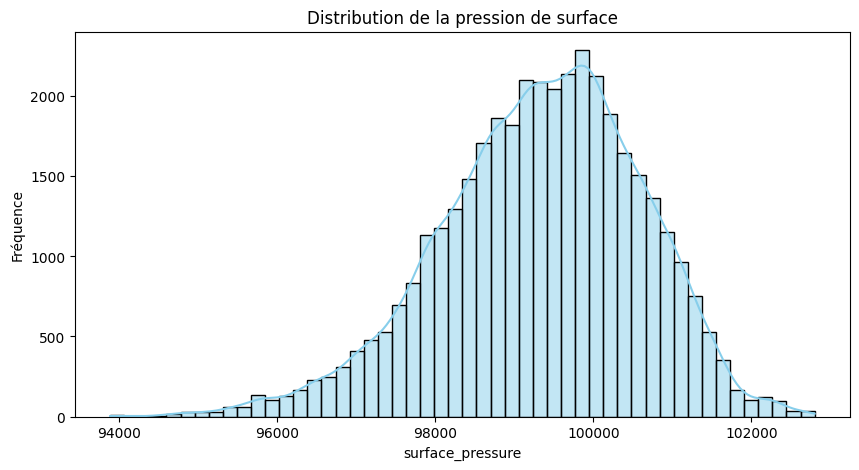

In [38]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["surface_pressure"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la pression de surface")
plt.xlabel("surface_pressure")
plt.ylabel("Fréquence")
plt.show()

MinMaxScaler  il est plus adapté aux données asymétriques et bornées.

In [39]:
from sklearn.preprocessing import MinMaxScaler

# Liste des colonnes à normaliser
colonnes_a_normaliser = ["Consommation" , "t2m_C"]

# Dictionnaire pour stocker les scalers (utile pour faire inverse_transform plus tard)
scalers = {}

# Copie du DataFrame pour ne pas modifier l'original
df_normalise = df_business_consumption.copy()

# Boucle sur chaque colonne à normaliser
for col in colonnes_a_normaliser:
    scaler = MinMaxScaler()
    df_normalise[col] = scaler.fit_transform(df_normalise[[col]])
    scalers[col] = scaler  # on garde le scaler si besoin d'inverser plus tard


StandardScaler pour la distribution normale
La normalisation standard transforme chaque valeur \( x \) selon la formule :

$$ 
z = \frac{x - \mu}{\sigma}
$$ 

où :

- `x` : la valeur brute  
- `μ` : la moyenne de toutes les valeurs  
- `σ` : l’écart type 

Le StandardScaler ne limite pas les valeurs à un intervalle fixe comme [0, 1]. Contrairement à MinMaxScaler, qui écrase tout entre deux bornes, StandardScaler transforme les données pour qu’elles aient :

    une moyenne = 0

    un écart-type = 1

In [40]:
# Colonnes à scaler avec StandardScaler
colonnes_standard = ["surface_pressure", "wind_speed"]

# Dictionnaire pour stocker les scalers
scalers = {}

# StandardScaler
for col in colonnes_standard:
    scaler = StandardScaler()
    df_normalise[col] = scaler.fit_transform(df_normalise[[col]])
    scalers[col] = scaler


In [41]:
# Encodage cyclique
df_normalise["hour_sin"] = np.sin(2 * np.pi * df_normalise["hour"] / 24)
df_normalise["hour_cos"] = np.cos(2 * np.pi * df_normalise["hour"] / 24)

df_normalise["month_sin"] = np.sin(2 * np.pi * df_normalise["month"] / 12)
df_normalise["month_cos"] = np.cos(2 * np.pi * df_normalise["month"] / 12)

df_normalise["weekday_sin"] = np.sin(2 * np.pi * df_normalise["weekday"] / 7)
df_normalise["weekday_cos"] = np.cos(2 * np.pi * df_normalise["weekday"] / 7)

df_normalise["dayofyear_sin"] = np.sin(2 * np.pi * df_normalise["dayofyear"] / 365)
df_normalise["dayofyear_cos"] = np.cos(2 * np.pi * df_normalise["dayofyear"] / 365)

In [42]:
df_normalise

,Date,wind_speed,t2m_C,surface_pressure,Consommation,hour,month,weekday,dayofyear,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
0,2021-01-01 00:00:00,-0.775388,0.350590,-0.356407,0.261538,0,1,4,1,0.000000e+00,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
1,2021-01-01 01:00:00,-0.839012,0.339167,-0.332534,0.257389,1,1,4,1,2.588190e-01,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2,2021-01-01 02:00:00,-0.931585,0.329652,-0.312523,0.264986,2,1,4,1,5.000000e-01,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
3,2021-01-01 03:00:00,-1.084743,0.322284,-0.314578,0.266281,3,1,4,1,7.071068e-01,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
4,2021-01-01 04:00:00,-1.263145,0.318771,-0.297702,0.282455,4,1,4,1,8.660254e-01,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38457,2025-05-22 09:00:00,0.843048,0.508829,0.384255,0.560058,9,5,3,142,7.071068e-01,-0.707107,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38458,2025-05-22 10:00:00,0.519997,0.506474,0.390666,0.550630,10,5,3,142,5.000000e-01,-0.866025,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38459,2025-05-22 11:00:00,0.695210,0.517676,0.405585,0.543712,11,5,3,142,2.588190e-01,-0.965926,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38460,2025-05-22 12:00:00,0.859432,0.524023,0.414782,0.522251,12,5,3,142,1.224647e-16,-1.000000,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659


In [43]:
df_normalise.index=df_normalise['Date']

df_normalise.drop(columns=["Date","hour", "month", "weekday", "dayofyear"], inplace=True)

df_normalise.head()

,wind_speed,t2m_C,surface_pressure,Consommation,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,,,
2021-01-01 00:00:00,-0.775388,0.350590,-0.356407,0.261538,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,-0.839012,0.339167,-0.332534,0.257389,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,-0.931585,0.329652,-0.312523,0.264986,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,-1.084743,0.322284,-0.314578,0.266281,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,-1.263145,0.318771,-0.297702,0.282455,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852


In [44]:
col = 'Consommation'
# Réorganiser les colonnes
df_normalise = df_normalise[[col] + [c for c in df_normalise.columns if c != col]]

In [45]:
df_normalise

,Consommation,wind_speed,t2m_C,surface_pressure,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,,,
2021-01-01 00:00:00,0.261538,-0.775388,0.350590,-0.356407,0.000000e+00,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,0.257389,-0.839012,0.339167,-0.332534,2.588190e-01,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,0.264986,-0.931585,0.329652,-0.312523,5.000000e-01,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,0.266281,-1.084743,0.322284,-0.314578,7.071068e-01,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,0.282455,-1.263145,0.318771,-0.297702,8.660254e-01,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-22 09:00:00,0.560058,0.843048,0.508829,0.384255,7.071068e-01,-0.707107,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
2025-05-22 10:00:00,0.550630,0.519997,0.506474,0.390666,5.000000e-01,-0.866025,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
2025-05-22 11:00:00,0.543712,0.695210,0.517676,0.405585,2.588190e-01,-0.965926,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659


In [47]:
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    """
    Dataset PyTorch pour séries temporelles avec prédiction multi-étapes (autoregressive).

    Chaque échantillon est constitué de :
      - sequence : un historique de longueur sequence_length, incluant avg_kwh_per_meter et les features cycliques/one-hot
      - target   : les future_steps prochaines valeurs de avg_kwh_per_meter
    """
    def __init__(self, df, sequence_length, future_steps):
        self.sequence_length = sequence_length
        self.future_steps = future_steps

        # Colonnes à utiliser : 
        cols = [
            'wind_speed',
            't2m_C',
            'surface_pressure',
            'Consommation',
            'hour_sin',
            'hour_cos',
            'month_sin',
            'month_cos',
            'weekday_sin',
            'weekday_cos',
            'dayofyear_sin',
            'dayofyear_cos'
        ]
        # On stocke les valeurs sous forme de numpy array
        self.data = df[cols].values

    def __len__(self):
        # Nombre total de séquences possibles
        return len(self.data) - self.sequence_length - self.future_steps

    def __getitem__(self, idx):
        # Séquence d'entrée : history_length pas de temps
        seq = self.data[idx : idx + self.sequence_length]                        # (sequence_length, input_size)
        # Cible : future_steps prochaines valeurs de avg_kwh_per_meter (col index 0)
        target = self.data[
            idx + self.sequence_length : 
            idx + self.sequence_length + self.future_steps, 
            0
        ]                                                                         # (future_steps,)

        # Conversion en tenseurs PyTorch
        seq_tensor    = torch.tensor(seq,    dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32)

        return seq_tensor, target_tensor

In [48]:
class ConsumptionLSTM(nn.Module):
    """
    Modèle LSTM pour prédire la consommation électrique multi-étapes
    à partir d'une séquence temporelle de features 
    (avg_kwh_per_meter, one-hot encoding, encodages cycliques).

    Paramètres :
        - input_size   : Nombre de features en entrée par pas de temps (ex. : 11)
        - hidden_size  : Nombre de neurones dans chaque couche cachée du LSTM
        - num_layers   : Nombre de couches LSTM empilées
        - future_steps : Nombre de pas de temps à prédire (output_size)
    """
    def __init__(self, input_size, hidden_size, num_layers, future_steps):
        super(ConsumptionLSTM, self).__init__()
        self.hidden_size  = hidden_size
        self.num_layers   = num_layers
        self.future_steps = future_steps

        # LSTM : batch_first=True → (batch, seq_len, input_size)
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True
        )

        # Couche linéaire de projection du dernier état caché
        self.fc = nn.Linear(hidden_size, future_steps)

    def forward(self, x):
        """
        Entrée :
            - x : Tensor (batch_size, sequence_length, input_size)
        Sortie :
            - out : Tensor (batch_size, future_steps)
        """
        lstm_out, _ = self.lstm(x)              # (batch, seq_len, hidden_size)
        last_step = lstm_out[:, -1, :]          # (batch, hidden_size)
        out = self.fc(last_step)                # (batch, future_steps)
        return out


In [49]:
import pandas as pd
from torch.utils.data import Subset, ConcatDataset, DataLoader, random_split

def split_category(df, seq_len, fut_steps, train_ratio=0.8):
    # 2) Créer le dataset
    ds = TimeSeriesDataset(df, seq_len, fut_steps)
    n = len(ds)
    n_train = int(train_ratio * n)
    # 3) Séparer sans mélanger
    train_ds = Subset(ds, list(range(n_train)))
    val_ds   = Subset(ds, list(range(n_train, n)))
    return train_ds, val_ds

# — paramètres
seq_len       = 48
fut_steps     = 24
batch_size    = 32

# — splits par catégorie
train, val = split_category(df_normalise,  seq_len, fut_steps)


# — DataLoaders (pas de shuffle pour conserver l’ordre)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val,   batch_size=batch_size, shuffle=False)

# —––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Vérification des dimensions du premier batch de train et val
# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

# 1) Train
train_batch = next(iter(train_loader))
x_train, y_train = train_batch
print("Train batch - inputs (x) shape:", x_train.shape)
print("Train batch - targets (y) shape:", y_train.shape)

# 2) Validation
val_batch = next(iter(val_loader))
x_val, y_val = val_batch
print("Validation batch - inputs (x) shape:", x_val.shape)
print("Validation batch - targets (y) shape:", y_val.shape)

# 3) Dimensions globales des datasets
print("Taille totale du train_dataset :", len(train))
print("Nombre de batches de train_loader :", len(train_loader))
print("Taille totale du val_dataset   :", len(val))
print("Nombre de batches de val_loader   :", len(val_loader))

Train batch - inputs (x) shape: torch.Size([32, 48, 12])
Train batch - targets (y) shape: torch.Size([32, 24])
Validation batch - inputs (x) shape: torch.Size([32, 48, 12])
Validation batch - targets (y) shape: torch.Size([32, 24])
Taille totale du train_dataset : 30712
Nombre de batches de train_loader : 960
Taille totale du val_dataset   : 7678
Nombre de batches de val_loader   : 240


In [50]:
import torch
import torch.nn as nn

##############################################
# 4. Instanciation du modèle, définition de la perte et de l'optimiseur
##############################################

# Paramètres du modèle adaptés à vos features :
#   - 1 avg_kwh_per_meter
#   - 3 colonnes one-hot (Business, Industry, Private)
#   - 6 encodages cycliques (hour_sin, hour_cos, dow_sin, dow_cos, month_sin, month_cos)
input_size   = 12     
hidden_size  = 128      # Nombre de neurones dans la couche cachée (modifiable)
num_layers   = 1       # Nombre de couches LSTM empilées
future_steps = 24      # Nombre d’heures (ou pas de temps) à prédire
output_size  = future_steps  # On prédit future_steps valeurs

# Instanciation du modèle
model = ConsumptionLSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    future_steps=future_steps
)

# Fonction de perte : Mean Squared Error pour régression multi-étapes
criterion = nn.MSELoss()

# Optimiseur : Adam (lr=0.001 par défaut)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

print(model)

ConsumptionLSTM(
  (lstm): LSTM(12, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=24, bias=True)
)


In [52]:
import torch

# 0) Choix du device
device = torch.device("cuda") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Utilisation du device : {device}")

# 1) Envoyer le modèle et la fonction de perte sur le device
model = model.to(device)
criterion = criterion.to(device)

##############################################
# 5. Boucle d'entraînement avec suivi des pertes (Train et Validation)
##############################################

num_epochs   = 10  # Nombre d'époques d'entraînement
train_losses = []
val_losses   = []

for epoch in range(num_epochs):
    # --- Phase d'entraînement ---
    model.train()
    epoch_train_loss = 0.0

    for sequences, targets in train_loader:
        # 1) Envoyer les données sur le device
        sequences = sequences.to(device)
        targets   = targets.to(device)

        optimizer.zero_grad()
        outputs = model(sequences)                       # (batch_size, future_steps)
        targets = targets.view_as(outputs)               # adapter la forme
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * sequences.size(0)

    epoch_train_loss /= len(train)
    train_losses.append(epoch_train_loss)

    # --- Phase de validation ---
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for sequences, targets in val_loader:
            # 1) Envoyer les données sur le device
            sequences = sequences.to(device)
            targets   = targets.to(device)

            outputs = model(sequences)
            targets = targets.view_as(outputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * sequences.size(0)

    epoch_val_loss /= len(val)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train Loss: {epoch_train_loss:.4f} — "
          f"Val Loss:   {epoch_val_loss:.4f}")

Utilisation du device : cpu
Epoch 1/10 — Train Loss: 0.7136 — Val Loss:   0.7228
Epoch 2/10 — Train Loss: 0.6018 — Val Loss:   0.6848
Epoch 3/10 — Train Loss: 0.5779 — Val Loss:   0.6663
Epoch 4/10 — Train Loss: 0.5647 — Val Loss:   0.6543
Epoch 5/10 — Train Loss: 0.5563 — Val Loss:   0.6461
Epoch 6/10 — Train Loss: 0.5502 — Val Loss:   0.6399
Epoch 7/10 — Train Loss: 0.5450 — Val Loss:   0.6344
Epoch 8/10 — Train Loss: 0.5403 — Val Loss:   0.6294
Epoch 9/10 — Train Loss: 0.5360 — Val Loss:   0.6254
Epoch 10/10 — Train Loss: 0.5310 — Val Loss:   0.6243


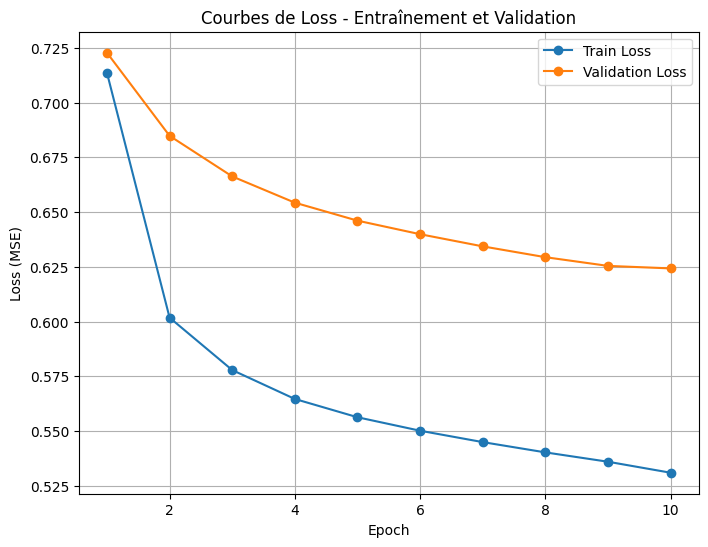

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Courbes de Loss - Entraînement et Validation')
plt.legend()
plt.grid(True)
plt.show()